In [80]:
import pandas as pd
import numpy as np
import time
import statsmodels.api as sm
import statsmodels.tsa as ts
plt.style.use('bmh')
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('Data/train.csv', parse_dates=['date'], index_col='date')

In [9]:
# The input file contains data for sales in 10 stores and 50 different items
data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


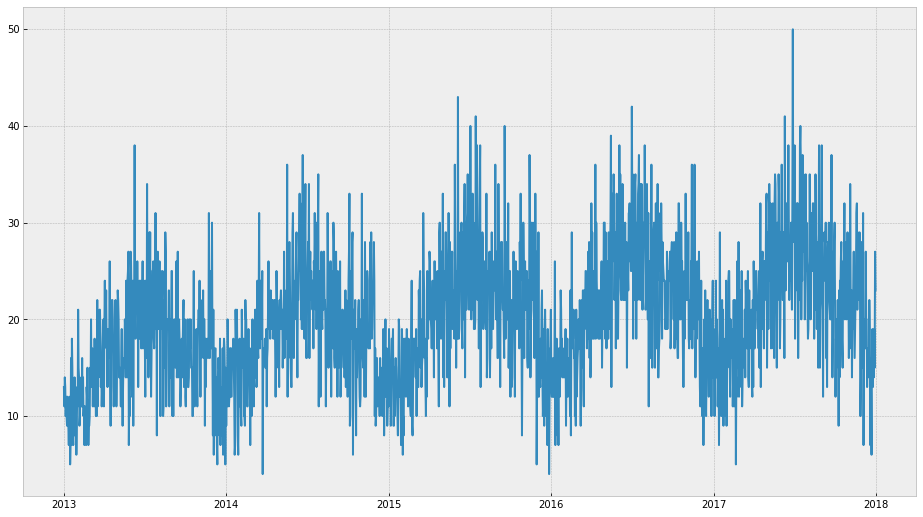

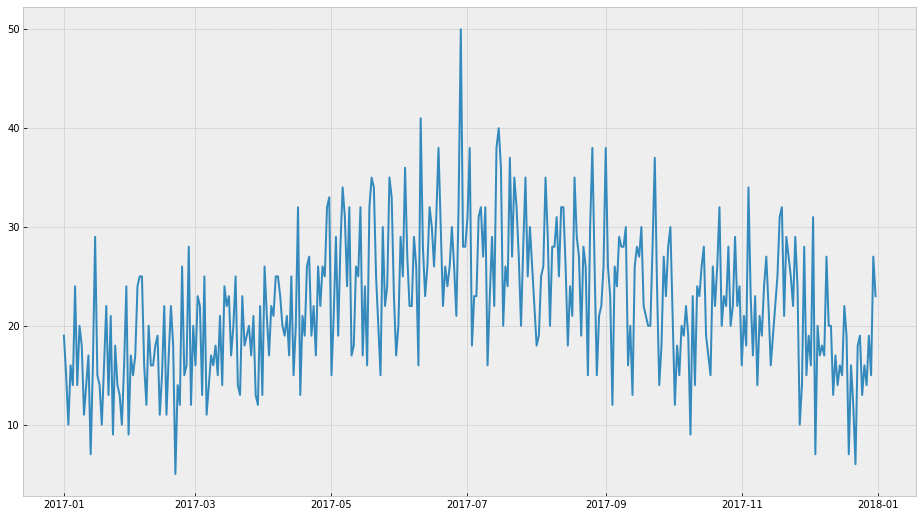

In [17]:
# Let's see what a time series looks like using matplotlib
store_1_item_1_time_series = data[data['store'].eq(1) & data['item'].eq(1)]['sales']
plt.figure(figsize=(16,9))
plt.plot(store_1_item_1_time_series)
plt.show()

# Last year
plt.figure(figsize=(16,9))
plt.plot(store_1_item_1_time_series.iloc[-365:])
plt.show()

# Clear seasonality patterns are evident in the graph, with peaks during the summer months
# The series is also characterized by a positive growth trend

,store,item,sales,day of week,day name
date,,,,,
2013-01-01,1,1,13,1,Tuesday
2013-01-02,1,1,11,2,Wednesday
2013-01-03,1,1,14,3,Thursday
2013-01-04,1,1,13,4,Friday
2013-01-05,1,1,10,5,Saturday


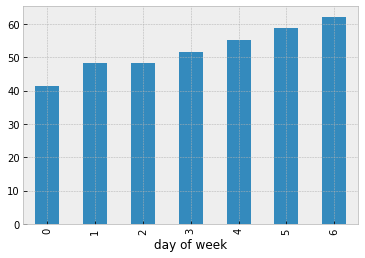

In [90]:
# Check whether weekly seasonality exists
data['day of week'] = data.index.dayofweek # add day of week column
data['day name'] = data.index.day_name()
display(data.head())
data.groupby('day of week')['sales'].mean().plot(kind='bar')
plt.show()
# Sales seem to be slighly larger during the weekends

# Drop the time period columns columns so we can later work on the original dataframe
data = data.drop(['day of week', 'day name'], axis=1) 

# Linear Regression

In [54]:
# In order to perform a linear regression on the seasonal components, we must first convert the data
# transforming categorical variables to dummy variables

def preprocess_series(series):
    data = pd.DataFrame()
    data['sales'] = series
    data['month'] = series.index.month # For monthly seasonality
    data['day_of_week'] = series.index.dayofweek # For weekly seasonality
    data['year'] = series.index.year # To account for trend
    # Convert seasonal variables to dummies
    data = pd.get_dummies(data, columns=['month', 'day_of_week'], drop_first=True)
    return data

In [55]:
# Check the output of a function
preprocessed_series = preprocess_series(store_1_item_1_time_series)
preprocessed_series.head()

,sales,year,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,
2013-01-01,13,2013,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2013-01-02,11,2013,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2013-01-03,14,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-04,13,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2013-01-05,10,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [56]:
# I'll now define some data manipulation functions that will be useful during training

# In general, we will want to train the algorithm on roughly 70-90% of the data, and then evaluate
# the performance on the rest. We will take the last year of data to evaluate the algorithm performance

def get_training_and_test_data(data):
    train_data_index = (data.index < '2017-01-01')
    train_data = data.loc[train_data_index] 
    test_data = data.loc[~train_data_index] # Take the complement of the train set for the test set
    return train_data, test_data

In [57]:
# This function simply splits the datasets, returning one table with regressors, and a series with
# the target variable

def split_regressors_and_target_variables(data, target_variable='sales'):
    regressors = data.drop(target_variable, axis=1)
    target = data[target_variable]
    return regressors, target

In [58]:
# Now we're ready to train our first model!

In [59]:
train_data, test_data = get_training_and_test_data(preprocessed_series)
X_train, y_train = split_regressors_and_target_variables(train_data)
X_test, y_test = split_regressors_and_target_variables(test_data)

In [60]:
# Instantiate an ordinary least squares regression model
model = sm.OLS(y_train, X_train)
# Train the model
model = model.fit()
# Now you can get the predictions on the test set
predictions = model.predict(X_test)

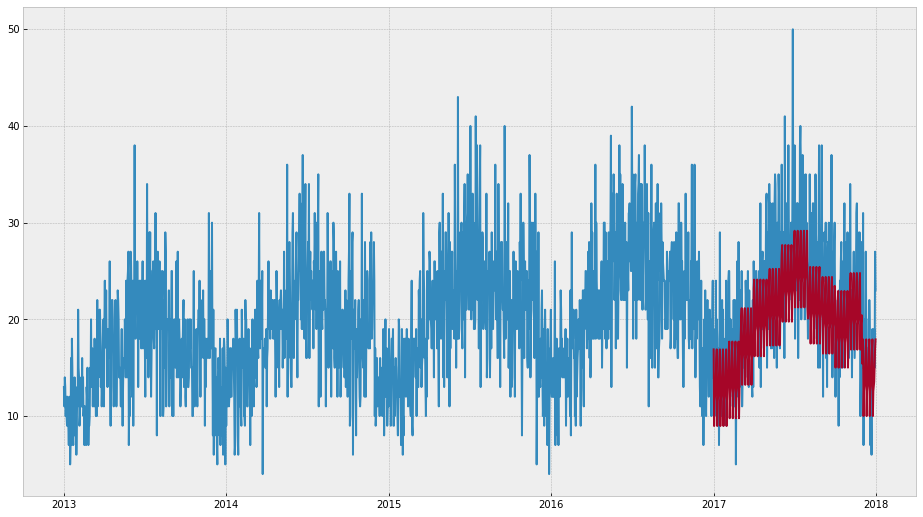

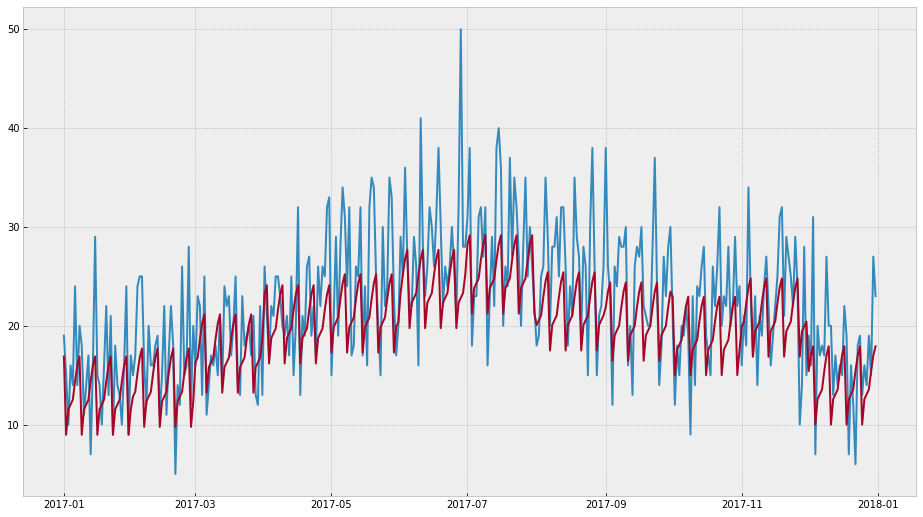

In [70]:
# Let's check how our model did on this example series with matplotlib
plt.figure(figsize=(16, 9))
plt.plot(store_1_item_1_time_series)
plt.plot(predictions)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(y_test)
plt.plot(predictions)
plt.show()

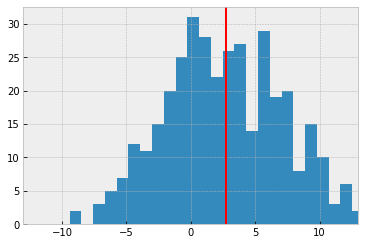

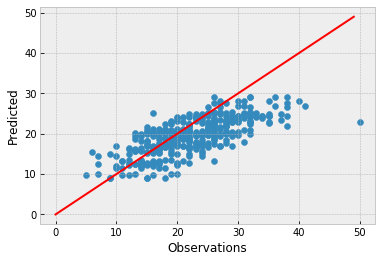

In [71]:
# It seems that in this particular case the model underestimated demand
# Let's check the error distribution
errors = y_test - predictions
mean_error = errors.mean()
plt.hist(errors, bins=40)
plt.xlim(-13, 13)
plt.axvline(mean_error, c='red')
plt.show()

# Let's see how predictions and observations are correlated
plt.scatter(y_test, predictions)
plt.xlabel('Observations')
plt.ylabel('Predicted')
plt.plot(list(range(50)), list(range(50)), color='red')
plt.show()

In [72]:
# We should calculate the Root Mean Squared Error (RMSE), in order to compare the performances 
# of each algorithm
def rmse(observations, predictions):
    return np.sqrt(np.square(observations - predictions).mean())

print(f'The RMSE was {rmse(y_test, predictions)}')

The RMSE was 5.536602770478944


In [73]:
# Good, now that we established the workflow for a single series, we should apply the algorithm to
# the whole dataset. We will be iterating through stores and items, performing a forecast 
# for each time series.
# We can take advantage of the pandas library group by function, but first let's wrap the whole
# training and prediction procedure in a single function:

def perform_forecast_on_series(series):
    
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(preprocessed_series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = sm.OLS(y_train, X_train)
    model = model.fit()
    predictions = model.predict(X_test)
    return predictions

In [116]:
%%time
# Let's apply the function to the dataset grouped by store and item
# Let's also time the algorithm, so we can later on evaluate how fast the algorithms were
result = data.groupby(['store', 'item'])['sales'].apply(perform_forecast_on_series).to_frame()
result = result.rename(columns={'sales': 'predicted'})

Wall time: 11.5 s


In [96]:
result

predicted
store item date                 
1     1    2017-01-01  16.896689
           2017-01-02   8.971285
           2017-01-03  11.550655
           2017-01-04  12.050509
           2017-01-05  12.524238
...                          ...
10    50   2017-12-27  13.080078
           2017-12-28  13.553806
           2017-12-29  15.420342
           2017-12-30  17.002182
           2017-12-31  17.926258

[182500 rows x 1 columns]

In [102]:
# Merge with the original dataframe
forecast = data.merge(result, on=['date', 'store', 'item'])
forecast.head(10)

,store,item,sales,predicted
date,,,,
2017-01-01,1,1,19,16.896689
2017-01-02,1,1,15,8.971285
2017-01-03,1,1,10,11.550655
2017-01-04,1,1,16,12.050509
2017-01-05,1,1,14,12.524238
2017-01-06,1,1,24,14.390774
2017-01-07,1,1,14,15.972613
2017-01-08,1,1,20,16.896689
2017-01-09,1,1,18,8.971285


In [104]:
# Save the result in the /Results folder
forecast.to_csv('Results/Linear_Regression.csv')

In [114]:
# Let's evaluate the performance of the Linear Regression model over the whole test dataset
print(f'The overall RMSE was {rmse(forecast.sales, forecast.predicted)}')
print(f'The mean error was {(forecast.sales - forecast.predicted).mean()}')

The overall RMSE was 49.49019117836901
The mean error was 39.370422254679475


In [111]:
# It looks like the RMSE calculated over the test dataset was significantly higher than in the
# first example. It also looks like the forecast was too pessimistic, as sales tended to be higher
# than the predictions. Let's see where the algorithm was least (and most) accurate
forecast['error'] = forecast['sales'] - forecast['predicted']
forecast['absolute_error'] = np.abs(forecast['error'])
sorted_by_abs_err = forecast.sort_values('absolute_error', ascending=False)
display(sorted_by_abs_err.head(10))
display(sorted_by_abs_err.tail(10))

,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-02,2,15,231,29.160780,201.839220,201.839220
2017-07-09,2,13,210,29.160780,180.839220,180.839220
2017-07-02,2,18,208,29.160780,178.839220,178.839220
2017-07-08,2,28,206,28.236703,177.763297,177.763297
2017-07-09,2,15,205,29.160780,175.839220,175.839220
2017-07-02,2,45,205,29.160780,175.839220,175.839220
2017-07-23,2,45,205,29.160780,175.839220,175.839220
2017-07-01,8,28,204,28.236703,175.763297,175.763297
2017-07-08,2,18,204,28.236703,175.763297,175.763297


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-12-04,3,5,10,10.000854,-0.000854,0.000854
2017-12-11,6,5,10,10.000854,-0.000854,0.000854
2017-12-11,4,41,10,10.000854,-0.000854,0.000854
2017-12-18,5,27,10,10.000854,-0.000854,0.000854
2017-12-25,3,27,10,10.000854,-0.000854,0.000854
2017-12-18,7,1,10,10.000854,-0.000854,0.000854
2017-12-04,2,1,10,10.000854,-0.000854,0.000854
2017-12-18,1,5,10,10.000854,-0.000854,0.000854
2017-12-18,7,37,10,10.000854,-0.000854,0.000854


In [122]:
# Since all of our models' outputs will be the same (date, store, item: prediction), we might 
# as well create a function to saves the results, and analyzes them

def model_report(original_data, model_output, model_name, n_rows_to_display=10):
    model_output = model_output.rename(columns={'sales': 'predicted'})
    forecast = original_data.merge(model_output, on=['date', 'store', 'item'])
    forecast.to_csv('Results/' + model_name + '.csv')
    forecast['error'] = forecast['sales'] - forecast['predicted']
    forecast['absolute_error'] = np.abs(forecast['error'])
    sorted_by_abs_err = forecast.sort_values('absolute_error', ascending=False)
    print('Most inaccurate')
    display(sorted_by_abs_err.head(n_rows_to_display))
    print('Most accurate')
    display(sorted_by_abs_err.tail(n_rows_to_display))
    print(f'The overall RMSE was {rmse(forecast.sales, forecast.predicted)}')
    print(f'The mean error was {(forecast.sales - forecast.predicted).mean()}')